# Retrieve tables with date conversion
## Example National accounts
The tables for national accounts have the characteristic that they have the same structure but different frequency. Then we can easily use the same query, and post it against different tables' metadata. to retrieve numbers
Main macroeconomic parameters:
- [09189](https://www.ssb.no/statbank/table/09189) - annually
- [09190](https://www.ssb.no/statbank/table/09190) - quarterly
- [11721](https://www.ssb.no/statbank/table/11721) - monthly



In [1]:
# Here we import various packages

import requests
import pandas as pd
from pyjstat import pyjstat # pyjstat is for processing JSON-stat


URL to the table's metadata in PxWebApi, whre we can post the queries

In [2]:
tabid = "09190" # try to run with id for both year (09189), quarter (09190) and month (11721)
lang = "en" # we can choose "one"
url1 = "https://data.ssb.no/api/v0/" + lang + "/table/" + tabid;

We ask for annual volume change for GDP and GDP Mainland Norway for the period 2010-2029 using "filter": "all". API query formulated as JSON.

In [3]:
query1 = {
  "query": [
    {
      "code": "Makrost",
      "selection": {
        "filter": "item",
        "values": [
          "bnpb.nr23_9",
          "bnpb.nr23_9fn"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "Volum"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "all",
        "values": [
         "201*",
          "202*"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}

Generell funksjon for å identifisere frekvens slik at vi kan konvertere til datoformat og sette [**Pandas PeriodIndex**](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-span-representation)

In [8]:
#funksjon for frequencies
def dateConv(dataframe):
    frekvens, frek_no, frek_en, fmt = findFrequency(dataframe)
    setPeriodIndex(frekvens, frek_no, frek_en, fmt, dataframe)
    
def findFrequency(dataframe):
    frekvenser = ['måned', 'kvartal', 'uke', 'år', 'year', 'quarter', 'month', 'week']
    frek_no = '' # SSB unfortunately uses Norwegian frequency codes:  U - week etc.
    frek_en = '' # English frequency code
    fmt = '' # python date format
    for w in frekvenser:
        if w in dataframe.columns:
            if w in ['måned', 'month']:
                frek_no = 'M'
                frek_en = 'M'
                fmt = '%YM%m'
            elif w in ['kvartal', 'quarter']:
                frek_no = 'K'
                frek_en = 'Q'
            elif w in ['uke', 'week']:
                frek_no = 'U';
                frek_en = 'W'
                fmt = '%YW%W-%w'
            else:
                frek_no = ''
                frek_en = 'A'
            return w, frek_no, frek_en, fmt
    
        
def setPeriodIndex(frekvens, frek_no, freq_en, fmt, df):
    if frekvens in ['kvartal', 'quarter']:
        # replaces K with Q, converts to date format and sets the frequency to Panda's PeriodIndex
        df.index = pd.PeriodIndex(pd.to_datetime(df[frekvens].str.replace(frek_no, freq_en), errors='coerce'), freq='Q-DEC')
    elif frekvens in ['uke', 'week']:
        df.index = pd.PeriodIndex(pd.to_datetime(df[frekvens].str.replace(frek_no, freq_en).add('-0'), format= fmt, errors='coerce'), freq='W-MON')
    else:
        df.index =  pd.PeriodIndex(pd.to_datetime(df[frekvens], format= fmt, errors='coerce'), freq=freq_en)



Here we post the query

In [9]:
res1 = requests.post(url1, json=query1)

Reading the result using the pyjstat library

In [10]:
ds1 = pyjstat.Dataset.read(res1.text)

Writes the result to a Pandas dataframe

In [11]:
df1 = ds1.write('dataframe')

In [12]:
df1.head(7)

,macroeconomic indicator,contents,quarter,value
0,"Gross domestic product, market values",Change in volume from the same period in the p...,2010K1,0.9
1,"Gross domestic product, market values",Change in volume from the same period in the p...,2010K2,2.5
2,"Gross domestic product, market values",Change in volume from the same period in the p...,2010K3,-1.4
3,"Gross domestic product, market values",Change in volume from the same period in the p...,2010K4,1.1
4,"Gross domestic product, market values",Change in volume from the same period in the p...,2011K1,-0.1
5,"Gross domestic product, market values",Change in volume from the same period in the p...,2011K2,-0.8
6,"Gross domestic product, market values",Change in volume from the same period in the p...,2011K3,4.3


Calls the function dateConv which converts to date.
Make a conversion from category to date format. This is then set as Panda's PeriodIndex

In [13]:
dateConv(df1)

Pandas PeriodIndex

In [14]:
df1.index

PeriodIndex(['2010Q1', '2010Q2', '2010Q3', '2010Q4', '2011Q1', '2011Q2',
             '2011Q3', '2011Q4', '2012Q1', '2012Q2',
             ...
             '2020Q2', '2020Q3', '2020Q4', '2021Q1', '2021Q2', '2021Q3',
             '2021Q4', '2022Q1', '2022Q2', '2022Q3'],
            dtype='period[Q-DEC]', name='quarter', length=102)

In [15]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 102 entries, 2010Q1 to 2022Q3
Freq: Q-DEC
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   macroeconomic indicator  102 non-null    object 
 1   contents                 102 non-null    object 
 2   quarter                  102 non-null    object 
 3   value                    102 non-null    float64
dtypes: float64(1), object(3)
memory usage: 4.0+ KB


Plot using Pandas groupby - gir two charts

macroeconomic indicator
Gross domestic product Mainland Norway, market values    AxesSubplot(0.125,0.11;0.775x0.77)
Gross domestic product, market values                    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

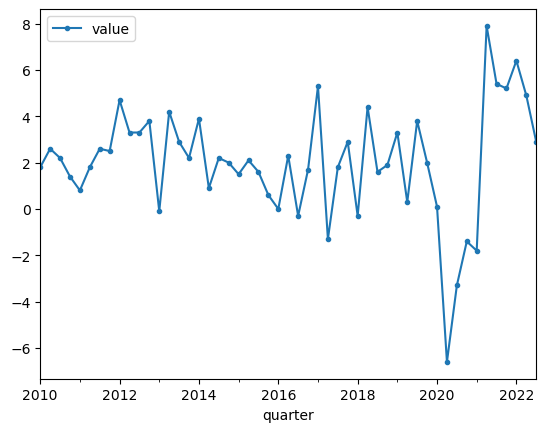

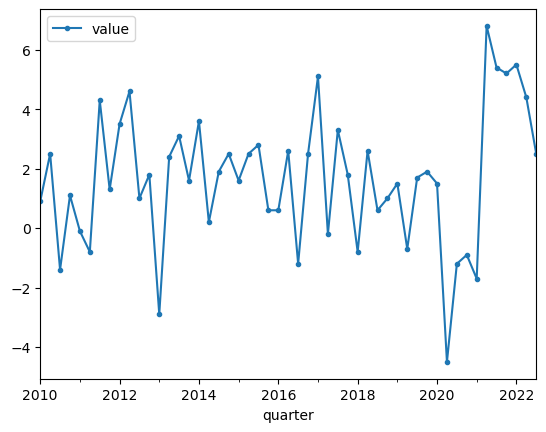

In [17]:
df1.groupby('macroeconomic indicator').plot( use_index=True, y='value', marker="o", markersize=3)

### pivot dataset in order to get one chart

In [19]:
df2 = df1.pivot(columns = 'macroeconomic indicator', values='value')

Increases size and sets SSB colors

<AxesSubplot: title={'center': 'GDP annual volume change in %'}, xlabel='quarter'>

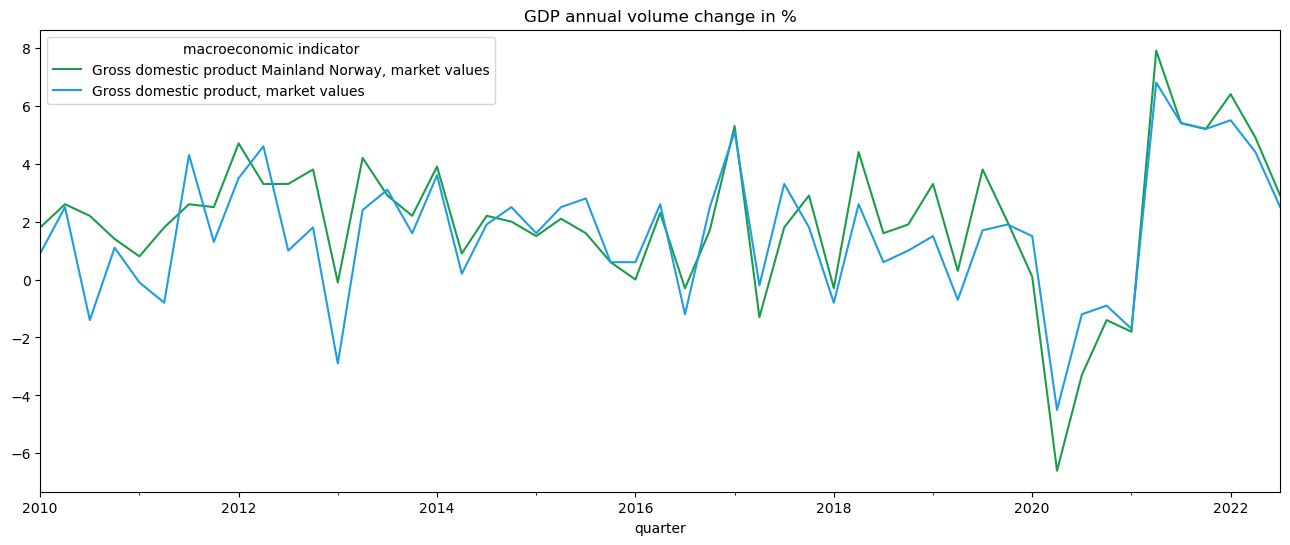

In [20]:
df2.plot(figsize=(16, 6), color=['#1a9d49', '#1d9de2'], title="GDP annual volume change in %")

In [21]:
df2.tail()

macroeconomic indicator,"Gross domestic product Mainland Norway, market values","Gross domestic product, market values"
quarter,,
2021Q3,5.4,5.4
2021Q4,5.2,5.2
2022Q1,6.4,5.5
2022Q2,4.9,4.4
2022Q3,2.9,2.5
